<img align="left" src = https://project.lsst.org/sites/default/files/Rubin-O-Logo_0.png width=250 style="padding: 10px"> 
<b>Introduction to Point Spread Function (PSF)</b> <br>
Contact author(s): Andrés A. Plazas Malagón<br>
Last verified to run:  w_2023_20 <br>
LSST Science Pipelines version: <br>
Container Size: medium <br>
Targeted learning level: beginner <br>

**Description:** This tutorial includes a description of the properties of the PSF, how to retrieve PSF information from catalogs and images, how to get the PSF kernel at any point in the image, how to display it as an image, how to calculate properties such as PSF, how to display the wavelength-dependence of the size, and how to produce useful diagnostic statistics such as correlation functions. 


**Skills:** Use of the catalog data products for PSF studies.

**LSST Data Products:** 

**Packages:** lsst.afw.image, lsst.afw.detection, lsst.rsp, lsst.daf.butler, lsst.geom, lsst.afw.display, lsst.analysis.tools

**Credit:** Developed by Andrés A. Plazas Malagón in collaboration with Melissa Graham and the Rubin Community Science Team for DP0.2.

Section on PSF size and its correlation function using `treecorr`: based on Jupyter notebook by Claire-Alice Hebert.

Section on PSF size histograms and dependency on central filter wavelength: based on Jupyter Notebook by Tianqing Zhang.

Section on `rho` statistics using `lsst.analaysis.tools`: based on Jupyter Notebook by Arun Kannawadi.


**Get Support:**
Find DP0-related documentation and resources at <a href="https://dp0-2.lsst.io">dp0-2.lsst.io</a>. Questions are welcome as new topics in the <a href="https://community.lsst.org/c/support/dp0">Support - Data Preview 0 Category</a> of the Rubin Community Forum. Rubin staff will respond to all questions posted there.

## 1. Introduction


One of the primary goals of extensive astronomical surveys, such as the Vera C. Rubin Legacy Survey of Space and Time (LSST), is to determine cosmological parameters by examining the slight deviations from statistical uniformity in the shapes and orientations of source galaxies caused by gravitational lensing from foreground large-scale structures. Nevertheless, the observed shapes of galaxies are influenced not only by the weak lensing of large scale structure of the universe ("cosmic shear") but also by a combined point spread function (PSF) generated by various factors such as the atmosphere (for ground-based instruments), telescope optics, and the image sensor. The convolution kernel, which represents the size and shape of this additional blurring effect, is typically determined by analyzing the observed images of stars, which act as point sources before being distorted by the PSF. An inaccurate modeling of the PSF could therefore lead to incorrect conclusions about the properties of dark matter and dark energy and the universe.

This tutorial studies the properies ofthe Point Spread Function using the DP0.2 dataset. It is composed of the following sections: 

 -  Section 2 produces an image of the PSF model at a particular location on the deep coadd image visualized in tutorial NB02. 

 - Section 3 calculates and displays the size of the PSF in a particular photometric band (`i`)  as function of sky location, and it computes the size-size two-point correlation function (autocorrelation) using the `treecorr` software, which is widely used in state-of-the-art weak lensing analyses to derive cosmological parameters. 

 - Section 4 illustrates one chromatic depedence of the PSF: the wavelength dependence of the PSF size. 

 - Section 5 calculates the `rho` statistics, a series of two-point correlation functions used to diagnose the quality of a PSF model for weak lensing analyses, using the `lsst.afw.analysis.tools` framework. 


#### Additional resources

<a href="https://rmjarvis.github.io/TreeCorr/_build/html/index.html">Treecorr documentation </a>

Chromatic effects of the PSF:

- Impact of Differential Chromatic Refraction (DCR) on weak lensing 
<a href="https://iopscience.iop.org/article/10.1086/668294/pdfhttps://iopscience.iop.org/article/10.1086/668294/pdf">: Plazas and Bernstein 2012 </a>
    
- Impact of DCR on Supernovae measurements <a href="https://iopscience.iop.org/article/10.3847/1538-3881/acca15/pdf">: Lee et al. 2023 </a>
    
- Impact of DCR, wavelength dependence of seeing, and other chromatic effects on weak lensing: <a href="https://iopscience.iop.org/article/10.1088/0004-637X/807/2/182/meta"> Meyers and Burchat 2015 </a>

PSF modeling and null tests for galaxy surveys, including `rho` statistics:

-  [Dark Energy Survey Y3 results: point spread function modeling](https://ui.adsabs.harvard.edu/abs/2021MNRAS.501.1282J/abstract)
-  [The three-year shear catalog of the Subaru Hyper Suprime-Cam SSP Survey](https://ui.adsabs.harvard.edu/abs/2022PASJ...74..421L/abstract)



### 1.1. Package Imports

The [matplotlib](https://matplotlib.org/) (and especially sublibrary `matplotlib.pyplot`), [numpy](http://www.numpy.org/), [scipy](https://scipy.org/https://scipy.org/), and [astropy](http://www.astropy.org/) libraries are widely used Python libraries for plotting, scientific computing, scientific analysis, and astronomical data analysis.

The `lsst.rsp` package provides access to the Table Access Protocol (TAP) service for queries to the DP0 catalogs.

The `lsst.afw.image` provide visualization tools.

The `lsst.afw.display` library provides access to image visualization routines and the `lsst.daf.butler` library is used to access data products via the butler.

The `lsst.afw.analysis.tools` library provides acces to analysis tools.

[treecorr](https://rmjarvis.github.io/TreeCorr/_build/html/index.html) by [Jarvis et al. 2004](https://ui.adsabs.harvard.edu/abs/2004MNRAS.352..338J/abstract) is a widely used tool for fast correlations measurements based on a ball tree method (similar to a k-d tree). In particular, it is widely used in state-of-the-art weak lensing cosmological analyses. 

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import treecorr

from scipy import stats
from scipy.optimize import curve_fit

import lsst.daf.butler as dafButler
import lsst.geom as geom
import lsst.afw.display as afwDisplay

from lsst.rsp import get_tap_service
from lsst.afw.image import MaskedImage
from lsst.geom import Point2D
from lsst.analysis.tools.atools import RhoStatistics



### 2. PSF visualization at a given location.

We'll create an image of the PSF model at a particular location in deepCoadd.


In [4]:
# Set a standard figure size to use
plt.rcParams['figure.figsize'] = (8.0, 8.0)
afwDisplay.setDefaultBackend('matplotlib')

Define the Butler instance for DP0.2 and select a particular `deepCoadd` image. We will pass the `tract` and `patch` numbers, as well as the desired band (`i`) in order to uniquely constrain the image. 


In [5]:
# Butler instance for DP0.2.
config = 'dp02'
collections = '2.2i/runs/DP0.2'
butler = dafButler.Butler(config, collections=collections)

In [6]:
datasetType = 'deepCoadd'  
dataId = {'tract': 4431, 'patch': 17, 'band': 'i'}
coadd = butler.get(datasetType, dataId=dataId)

We will use `computeKernelImage` to display the pixel-based model of teh PSF at a particular point. 

In [7]:
# Use computeKernelImage at a chosen point. 

info = coadd.getInfo()
psf = info.getPsf()
psf_kernel = psf.computeKernelImage(Point2D(13000, 8500))
first_psf_image = psf_kernel.convertF()

(-28.5, 28.5, -28.5, 28.5)

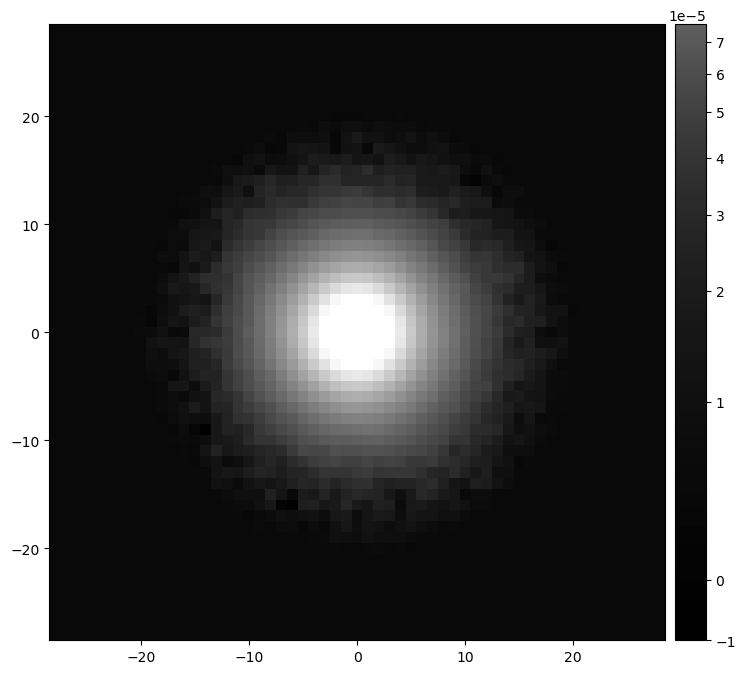

In [8]:
fig = plt.figure(figsize=(10, 8))
afw_display = afwDisplay.Display(1)
afw_display.scale('asinh', 'zscale')
afw_display.mtv(first_psf_image)
plt.gca().axis('on')

Note how the coordinates of the image have their origin at the center of the image.
The coordinates of the origin are (0,0), so the lower left point has negative
coordinates: 

In [9]:
first_psf_image.getXY0()

Point2I(-28, -28)

Now, instead of `computeKernelImage`, we'll use
`computeImage`. 
One have the PSF center at the center of the 
central pixel in the stamp or cutout (computeKernelImage), and 
the other one (computeImage) can make it at any arbitrary location.

In [10]:
wcs = info.getWcs()
second_psf_image = psf.computeImage(wcs.skyToPixel(wcs.pixelToSky(13000, 8500))).convertF()



(12971.5, 13028.5, 8471.5, 8528.5)

<Figure size 1000x800 with 0 Axes>

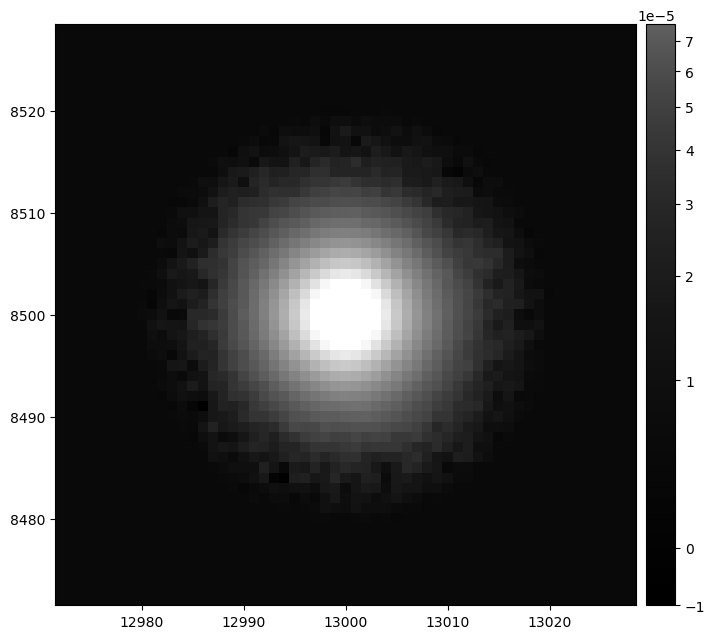

In [11]:
fig = plt.figure(figsize=(10, 8))
afw_display = afwDisplay.Display(2)
afw_display.scale('asinh', 'zscale')
afw_display.mtv(second_psf_image)
plt.gca().axis('on')

In [12]:
# Look at the coordinates in the lower-left corner

second_psf_image.getXY0()

Point2I(12972, 8472)

#### 3. Size of the PSF and its correlation function using treecorr

In this section we will plot the size of the PSF in the `i` band as function of celestial coordinates. We will use the TAP service to retrieve point sources from the `deepCoadd` catalog, along with the necessary quantities. After calculating the PSF size from the modeled PSF second moments, we'll visualize it as a function of sky coordinates. In addition, we will use the `treecorr` software to calculate the two point correlation function of the size as a funtion of angular separation. Two-point correlations functions are widely used in weak lensign cosmological analysis to infer cosmological parameters, and `treecorr` is the standard tool currently used by many collaborations (e.g., the Dark Energy Surve and the Hyper-Suprime Camera Survey).

#### 3.1 Cone Search 
Let's do a cone search (c.f., NB02) around the DC2 center point, with a search radius of 2 degrees.

In [13]:
use_center_coords = "62, -37"


In [14]:
service = get_tap_service("tap")

In [15]:
results = service.search("SELECT TOP 1000000"
                         "coord_ra, coord_dec, "
                         "scisql_nanojanskyToAbMag(u_psfFlux) as u_psfMag, "
                         "scisql_nanojanskyToAbMag(g_psfFlux) as g_psfMag, "
                         "scisql_nanojanskyToAbMag(r_psfFlux) as r_psfMag, "
                         "scisql_nanojanskyToAbMag(i_psfFlux) as i_psfMag, "
                         "scisql_nanojanskyToAbMagSigma(i_psfFlux, i_psfFluxErr) as i_psfMagErr, "
                         "i_ixx, i_iyy, i_ixxPSF, i_iyyPSF, i_psfFlux, i_psfFlux_flag, "
                         "i_pixelFlags_saturatedCenter, i_extendedness_flag, "
                         "xy_flag, detect_isPatchInner, detect_isDeblendedSource, "
                         "i_psfFluxErr, i_extendedness, i_ixy, i_ixyPSF, "
                         "g_ixx, g_iyy, g_ixxPSF, g_iyyPSF, "
                         "r_ixx, r_iyy, r_ixxPSF, r_iyyPSF, "
                         "u_ixx, u_iyy, u_ixxPSF, u_iyyPSF  "
                         "FROM dp02_dc2_catalogs.Object "
                         "WHERE CONTAINS(POINT('ICRS', coord_ra, coord_dec), "
                         "CIRCLE('ICRS', "+use_center_coords+", 2.0)) = 1 "
                         "AND detect_isPrimary = 1 "
                         "AND i_calibFlux > 360 "
                         "AND i_extendedness < 0.5 "
                         "AND i_calib_psf_used = 1 "
                         "AND i_pixelFlags_inexact_psfCenter = 0 ")

results_table = results.to_table().to_pandas()
print(len(results_table))

9964


In the above query, we use the `Object` catalog, which contains the `deepCoadd` objects (see the
<a href="https://dm.lsst.org/sdm_schemas/browser/dp02.html#Objecthttps://dm.lsst.org/sdm_schemas/browser/dp02.html#Object">DP0.2 schema browserDP0.2 schema browser </a>). We request the PSF fluxes in different bands, obtained from fitting a PSF model to a selected group of stars. The second moments of the PSF, `{band}_ixxPSF`,`{band}_ixyPSF`, and `{band}_iyyPSF` will be used to calculatethe PSF size in each band. In this section we willl only plot the size of the PSF in one band (`i`), but section 4 below will demonstrate the chromatic dependence of the PSF size and for that we will use the otehr bands. In order to detect point sources, we set the flags `detect_isPrimary` and `i_extendedness` to 1 and less that 0.5, respectively. The `i_calib_psf_used` flag ensures that we select stars that were used (as opposed to reserved)  in the determination of the PSF model. The flag `i_pixelFlags_inexact_psfCenter = 0` ensures that the objects are not near edges. 

The previous query should result in 9964 entries: 

In [16]:
print(len(results_table))

9964


#### 3.2 Size calculation, visualization, and two-point correlation function calculation. 

The trace of the moments matrix in each band, `T = {band}_ixxPSF + {band}_iyyPSF` will be used to calculate the "trace radius" (in pixels) `sqrt(T/2)` of the PSF model in each band, as a mesure of its size. 

In [39]:
results_table['size_g_PSF'] = np.sqrt( (results_table['g_ixxPSF'] + results_table['g_iyyPSF'] ) /2)
results_table['size_r_PSF'] = np.sqrt( (results_table['r_ixxPSF'] + results_table['r_iyyPSF'] ) /2)
results_table['size_i_PSF'] = np.sqrt( (results_table['i_ixxPSF'] + results_table['i_iyyPSF'] ) /2)
results_table['size_u_PSF'] = np.sqrt( (results_table['u_ixxPSF'] + results_table['u_iyyPSF'] ) /2)

In [20]:
ra = results_table['coord_ra']
dec = results_table['coord_dec']

Let's define `treecorr`'s catalog and adjust a few of its parameters. For more information abotu `treecorr`, check its [documentation](https://rmjarvis.github.io/TreeCorr/_build/html/index.html). 

In [21]:
cat = treecorr.Catalog(ra=ra, dec=dec, k=results_table['size_i_PSF'] - np.mean(results_table['size_i_PSF'] ), 
                       ra_units='deg', dec_units='deg')

kk_config = {'max_sep': .06, 'min_sep': .0001, 'nbins': 12}


Let's now calculate the two-point correlation function of the size. In this case, this is an auto-correlation (size-size two point correlation):

In [22]:
kk = treecorr.KKCorrelation(kk_config)
kk.process(cat)

Retrieve the correlation function, `xi`, and the angular separation arrays:

In [23]:
xi = kk.xi
bins = kk.rnom

Plot the size in the searched circle, and the correlation function next to it

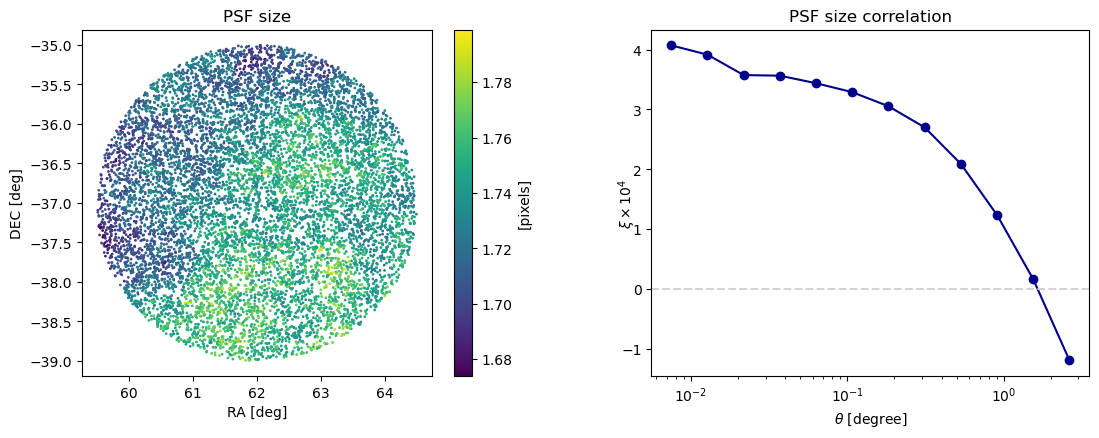

In [24]:
_ , (a1, a2) = plt.subplots(1,2, figsize=(13, 4.5), gridspec_kw={'wspace':.3})

a1.set_title('PSF size')
scatter_plot = a1.scatter(ra, dec, c=results_table['size_i_PSF'] , s=1, cmap='viridis')
a1.set_xlabel('RA [deg]')
a1.set_ylabel('DEC [deg]')
plt.colorbar(scatter_plot, ax=a1, label='[pixels]')

a2.set_title('PSF size correlation')
a2.plot(np.degrees(bins), xi*1e4, 'o-', color='darkblue')
a2.axhline(0, linestyle='--', color='lightgrey')
a2.set_xscale('log')
a2.set_ylabel(r'$\xi \times 10^{4}$', labelpad=-12)
a2.set_xlabel(r'$\theta$ [degree]')

plt.show()

### 4. Wavelength dependence of seeing  

In order to correct for the PSF and measure the galaxy shapes to infer the weak lesning signal ("shear"), the PSF is modeled from stars (usually bright stars) and then the galaxy images are deconvolved using the estimated convolution kernel (the PSF).  Implicit in this approach is the assumption that the convolution kernel for galaxies is identical to that for stars. However, if the PSF varies with wavelength, this assumption is invalid due to the distinct spectral energy distributions (SEDs) of stars and galaxies, resulting in different PSFs.

In this section, we'll use the sample of point sources retrieved in previous sections to calculate one of the wavelength-dependent contributions to the PSF due to the atmosphere: the wavelength dependence on seeing (other contributions include, for example, Differential Chromatic Refraction).  The standard theory of atmospheric turbulence predicts that the linear size `θ` of the atmospheric convolution kernel (i.e., the seeing) is related to wavelength as `θ ∝ λ**−1/5`. 





In order to reproduce this wavelength relationship with our data, we'll start by calculating the central wavelengths of the braodband filters that LSST will use, as well as the mean size and its standard deviation per band. 

In [40]:
# Filter centers 
# Table 2.1: https://www.lsst.org/sites/default/files/docs/sciencebook/SB_2.pdf 
wavelength = 0.5*np.array([320+400, 400+552, 552+691, 691+818])

mean_size = [np.mean(results_table['size_u_PSF']), np.mean(results_table['size_g_PSF']), np.mean(results_table['size_r_PSF']), 
             np.mean(results_table['size_i_PSF'])]

std_size = [np.std(results_table['size_u_PSF']), np.std(results_table['size_g_PSF']), np.std(results_table['size_r_PSF']), 
            np.std(results_table['size_i_PSF'])]



We will now fit a power law to the mean PSF size as a function of wavelength. 

In [41]:
# Fit size vs wavelength
def power(lam,a,b):
    return a*lam**(-b)


In [42]:
popt, pcov = curve_fit(power, wavelength, mean_size)

In [49]:
lamb_grid = np.arange(300, 800, 1)
fit_size = power(lamb_grid, *popt)
amplitude, exponent = popt
print (f"Amplitude: {amplitude}")
print (f"Exponent: {exponent}")

Amplitude: 6.324319066243073
Exponent: 0.19581110730904414


The fitted exponent, `-0.195`, is close to the expected value of `-1/5=0.2`. 

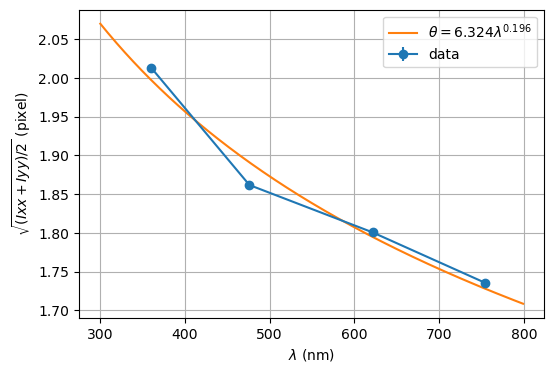

In [55]:
plt.figure(figsize = (6,4))
plt.errorbar(wavelength, mean_size , std_size/np.sqrt(len(results_table)) , fmt='o-', label='data')
plt.plot(lamb_grid, fit_size, label = r'$\theta = %.3f \lambda^{%.3f}$' %(amplitude, exponent))
plt.xlabel(r'$\lambda$ (nm)')
plt.ylabel(r'$\sqrt{(Ixx+Iyy)/2}$ (pixel)')
plt.grid()
plt.legend()
plt.show()

In the followign plot, we will over plot the size distributions per band ove rthe plot derived above.

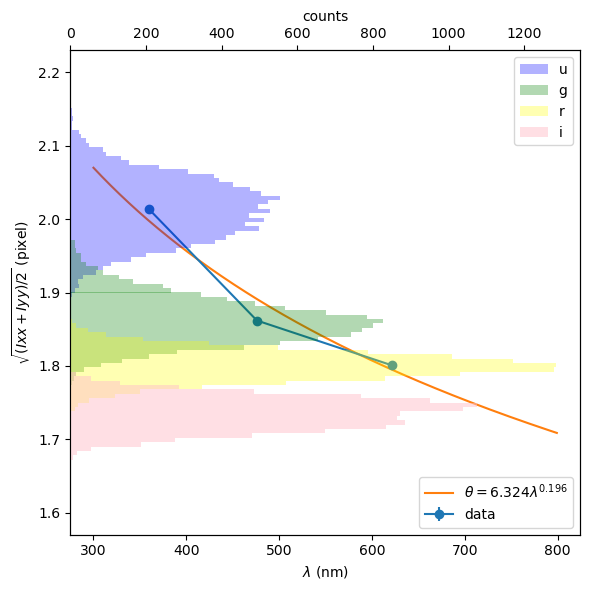

In [56]:



fig, ax1 = plt.subplots(figsize = (6,6))

color = 'tab:red'
ax1.set_xlabel(r'$\lambda$ (nm)')
ax1.set_ylabel(r'$\sqrt{(Ixx+Iyy)/2}$ (pixel)')
ax1.errorbar(wavelength[:-1], mean_size[:-1] , std_size[:-1]/np.sqrt(len(results_table)) , fmt='o-', label='data')
ax1.plot(lamb_grid, fit_size, label =r'$\theta = %.3f \lambda^{%.3f}$' %(amplitude, exponent))
ax1.legend(loc='lower right')
ax1.tick_params(axis='y')

ax2 = ax1.twiny()  # instantiate a second axes that shares the same x-axis

ax2.set_xlabel('counts')  # we already handled the x-label with ax1
plt.hist(results_table['size_u_PSF'], bins = 100, range = [1.6, 2.2], color = 'blue', alpha = 0.3, label = 'u',orientation="horizontal")
plt.hist(results_table['size_g_PSF'], bins = 100, range = [1.6, 2.2], color = 'green', alpha = 0.3, label = 'g',orientation="horizontal")
plt.hist(results_table['size_r_PSF'], bins = 100, range = [1.6, 2.2], color = 'yellow', alpha = 0.3, label = 'r',orientation="horizontal")
plt.hist(results_table['size_i_PSF'], bins = 100, range = [1.6, 2.2], color = 'pink', alpha = 0.5, label = 'i',orientation="horizontal")
plt.legend()
ax2.tick_params(axis='y')

fig.tight_layout() 
plt.show()




### 5. Rho statistics with analysis tools 


We'll use `lsst.analysys.tools` to calculate the `rho` statistics. To see how they are defined, see the analysis tool documentation [here](https://pipelines.lsst.io/v/daily/py-api/lsst.analysis.tools.actions.vector.CalcRhoStatistics.html#lsst.analysis.tools.actions.vector.CalcRhoStatistics). `lsst.analysys.tools`, in turn, uses `treecorr` to perform the actual calculations. 


In [57]:
atool = RhoStatistics()


Let's use stars with with S/N > 20

In [58]:
atool.prep.selectors.snSelector.threshold = 20.0  

As in a previous section, we can adjust the `treecorr` parameters before calculations.

In [59]:
atool.process.calculateActions.rho.treecorr.nbins = 21
atool.process.calculateActions.rho.treecorr.min_sep = 0.1
atool.process.calculateActions.rho.treecorr.max_sep = 100.0

We need to call `finalize()` after the `prep` and `process` stages are configured.


In [60]:
atool.finalize()

In [61]:
input_schema = atool.getInputSchema()
input_schema

<generator object BasePrep.getInputSchema at 0x7fc883672960>

In [62]:
from pprint import pprint
pprint(list(input_schema))


[('coord_ra',
  numpy.ndarray[typing.Any, numpy.dtype[+ScalarType]] | lsst.analysis.tools.interfaces._interfaces.Scalar),
 ('coord_dec',
  numpy.ndarray[typing.Any, numpy.dtype[+ScalarType]] | lsst.analysis.tools.interfaces._interfaces.Scalar),
 ('{band}_ixx',
  numpy.ndarray[typing.Any, numpy.dtype[+ScalarType]] | lsst.analysis.tools.interfaces._interfaces.Scalar),
 ('{band}_iyy',
  numpy.ndarray[typing.Any, numpy.dtype[+ScalarType]] | lsst.analysis.tools.interfaces._interfaces.Scalar),
 ('{band}_ixy',
  numpy.ndarray[typing.Any, numpy.dtype[+ScalarType]] | lsst.analysis.tools.interfaces._interfaces.Scalar),
 ('{band}_ixxPSF',
  numpy.ndarray[typing.Any, numpy.dtype[+ScalarType]] | lsst.analysis.tools.interfaces._interfaces.Scalar),
 ('{band}_iyyPSF',
  numpy.ndarray[typing.Any, numpy.dtype[+ScalarType]] | lsst.analysis.tools.interfaces._interfaces.Scalar),
 ('{band}_ixyPSF',
  numpy.ndarray[typing.Any, numpy.dtype[+ScalarType]] | lsst.analysis.tools.interfaces._interfaces.Scalar),
 (

Now we are ready to compute the `rho` statistics.

In [63]:
prepResults = atool.prep(results_table, band='i')
processResults = atool.process(prepResults, band='i')

Let's plot the `rho` statistics. 

In [65]:
atool.produce.plot.rhoPlots["rho3"].yLinThresh = 1e-10
atool.produce.plot.rhoPlots["rho4"].yLinThresh = 1e-10
atool.produce.plot.rhoPlots["rho5"].yLinThresh = 1e-10

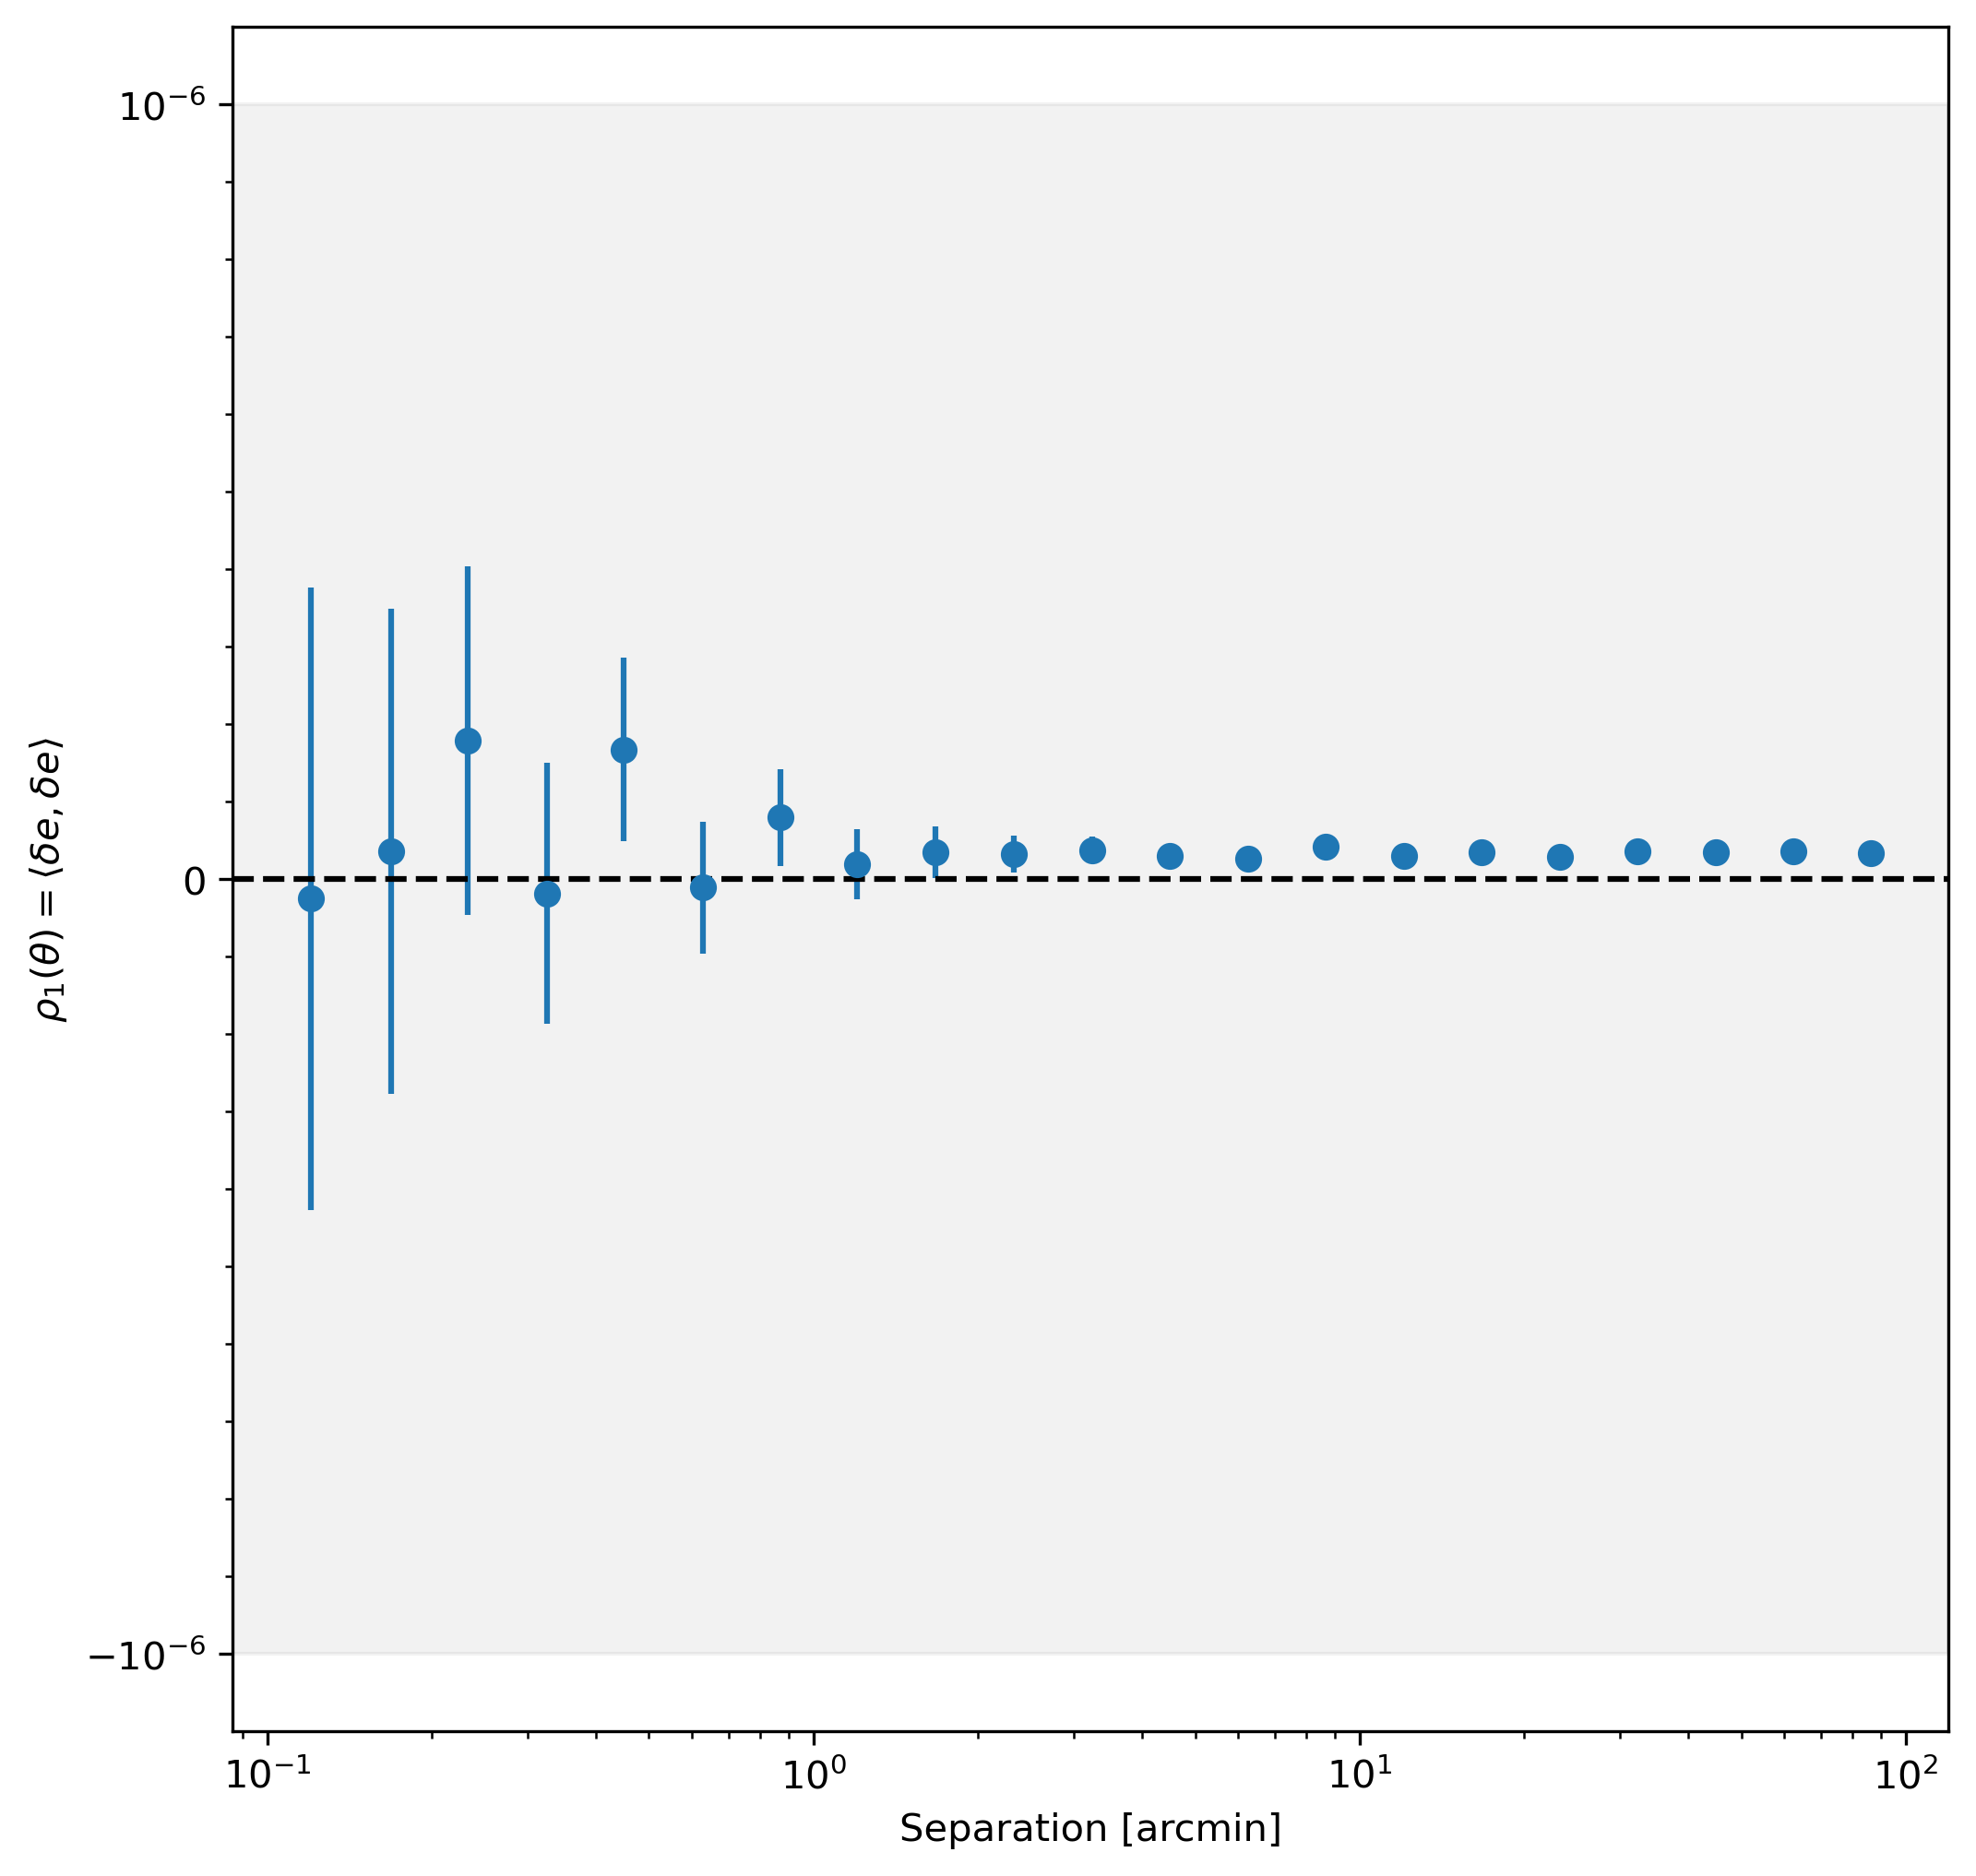

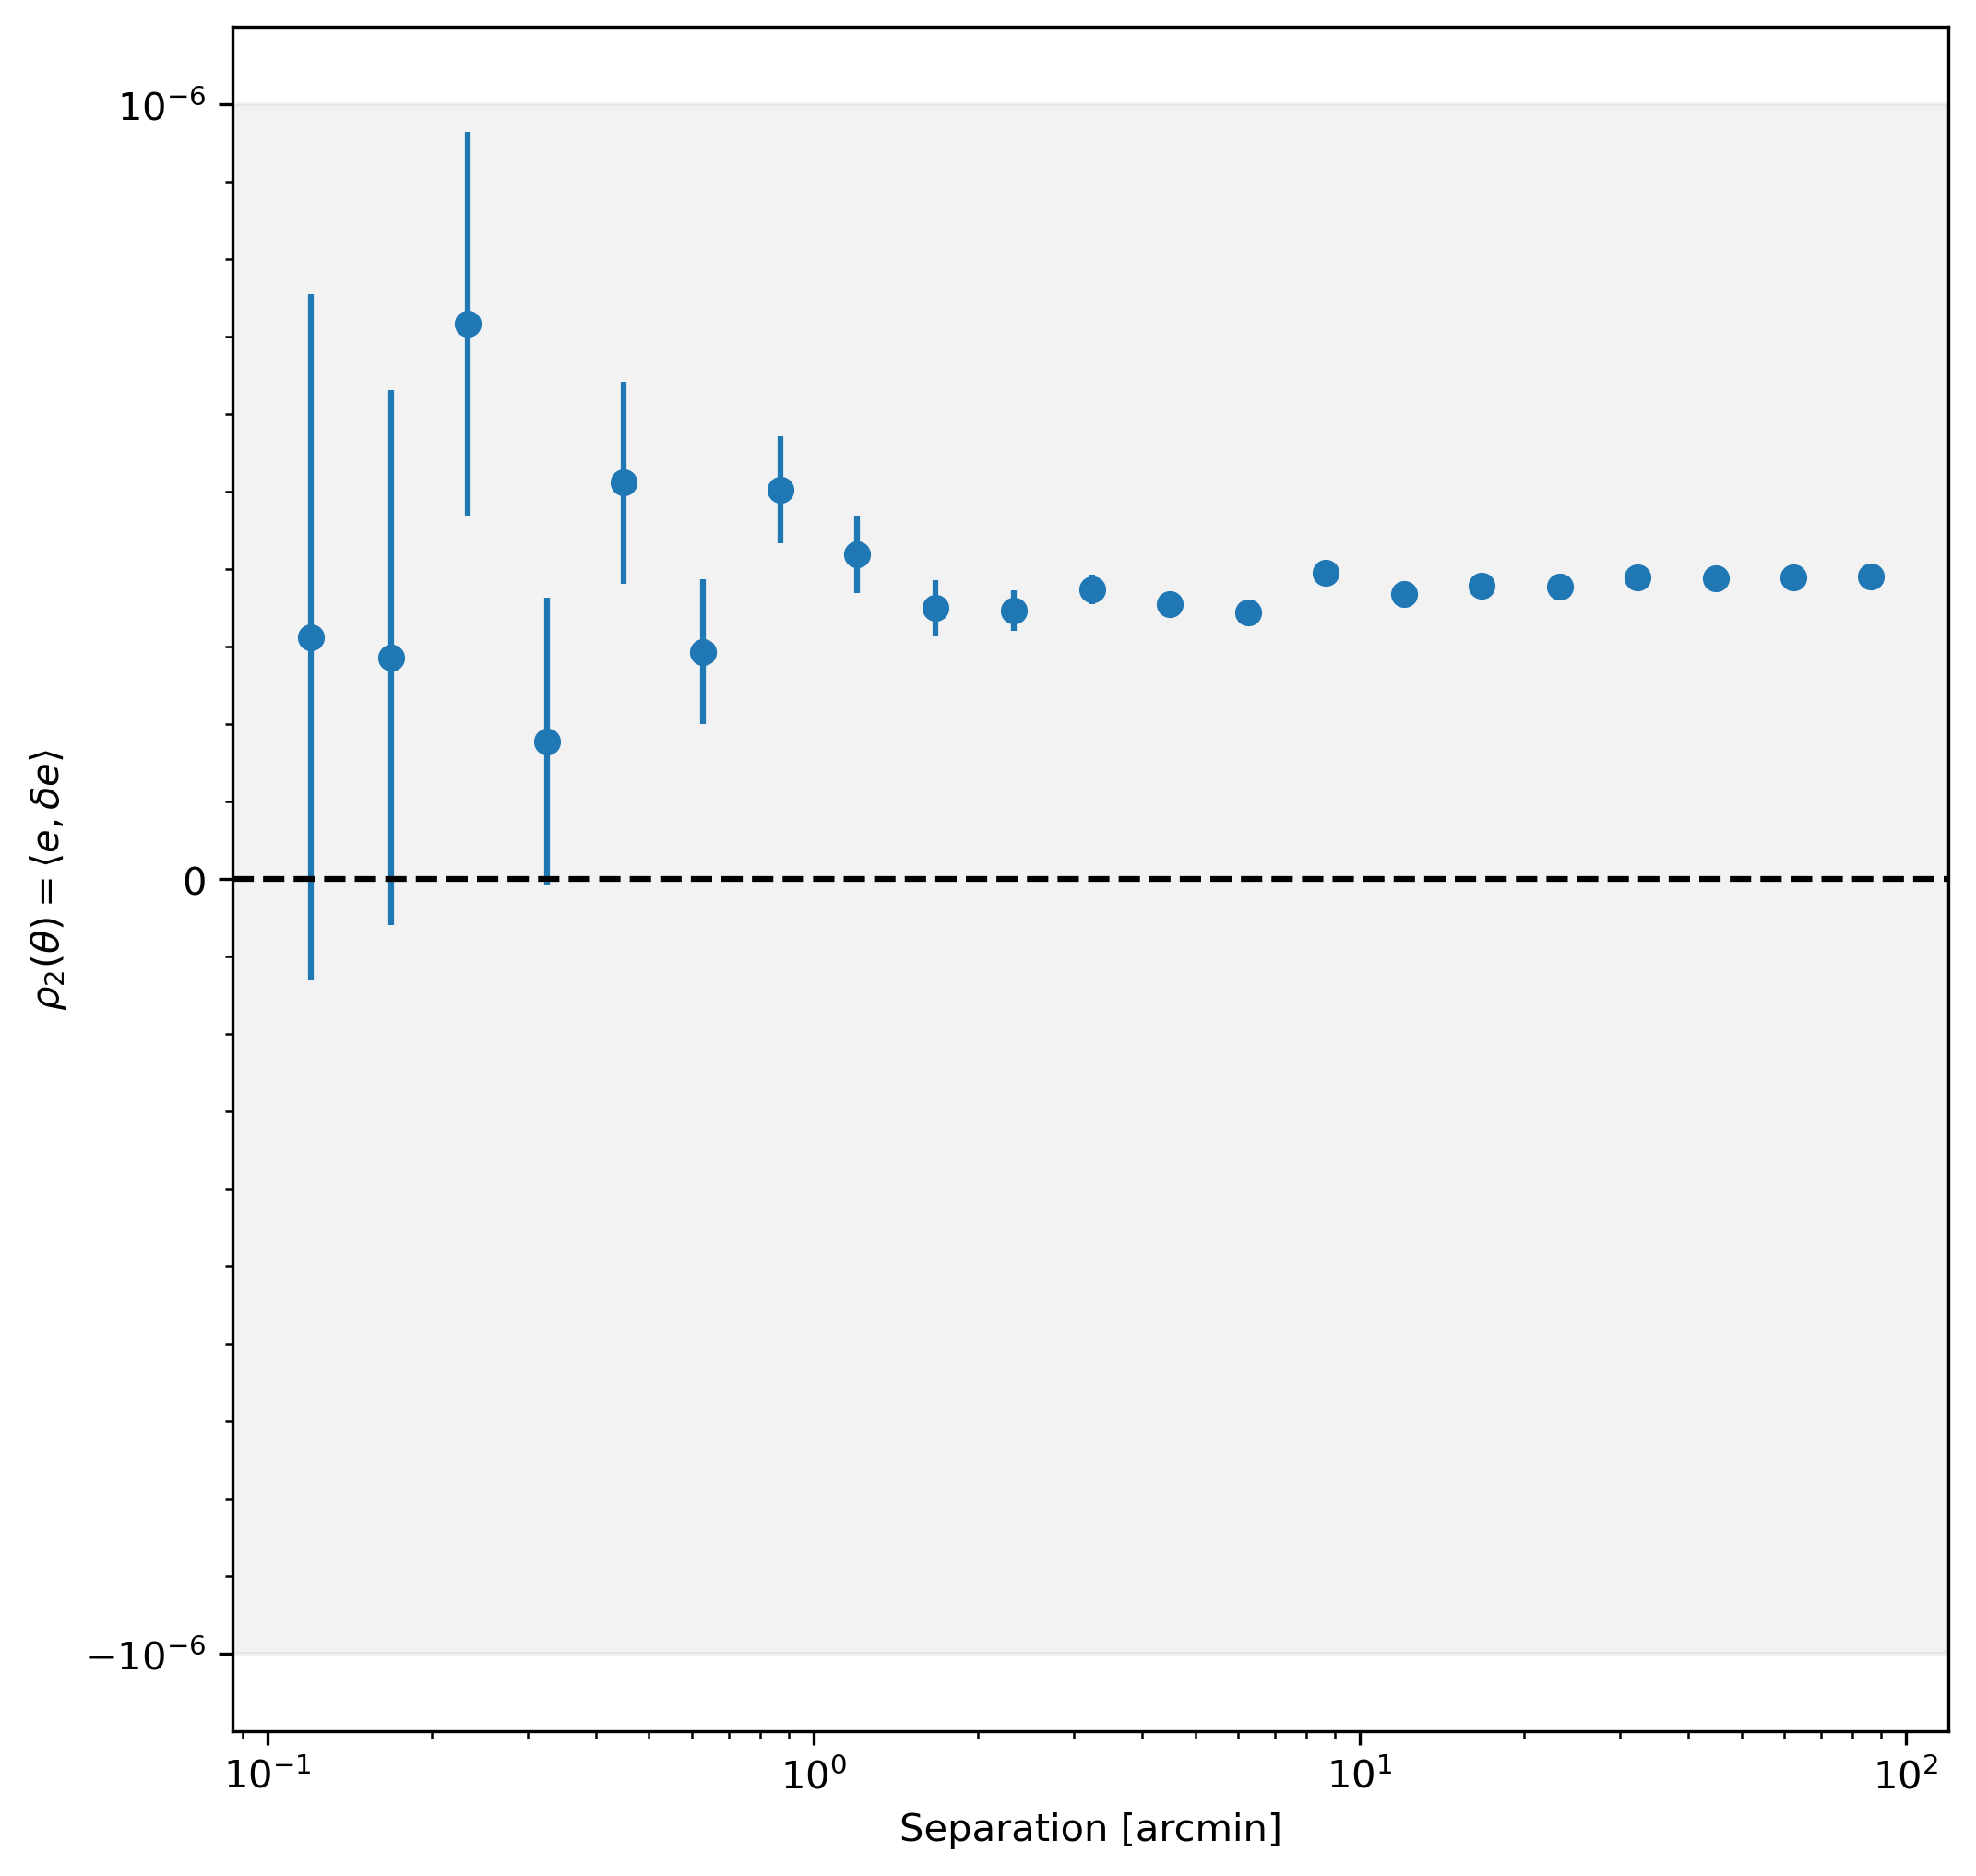

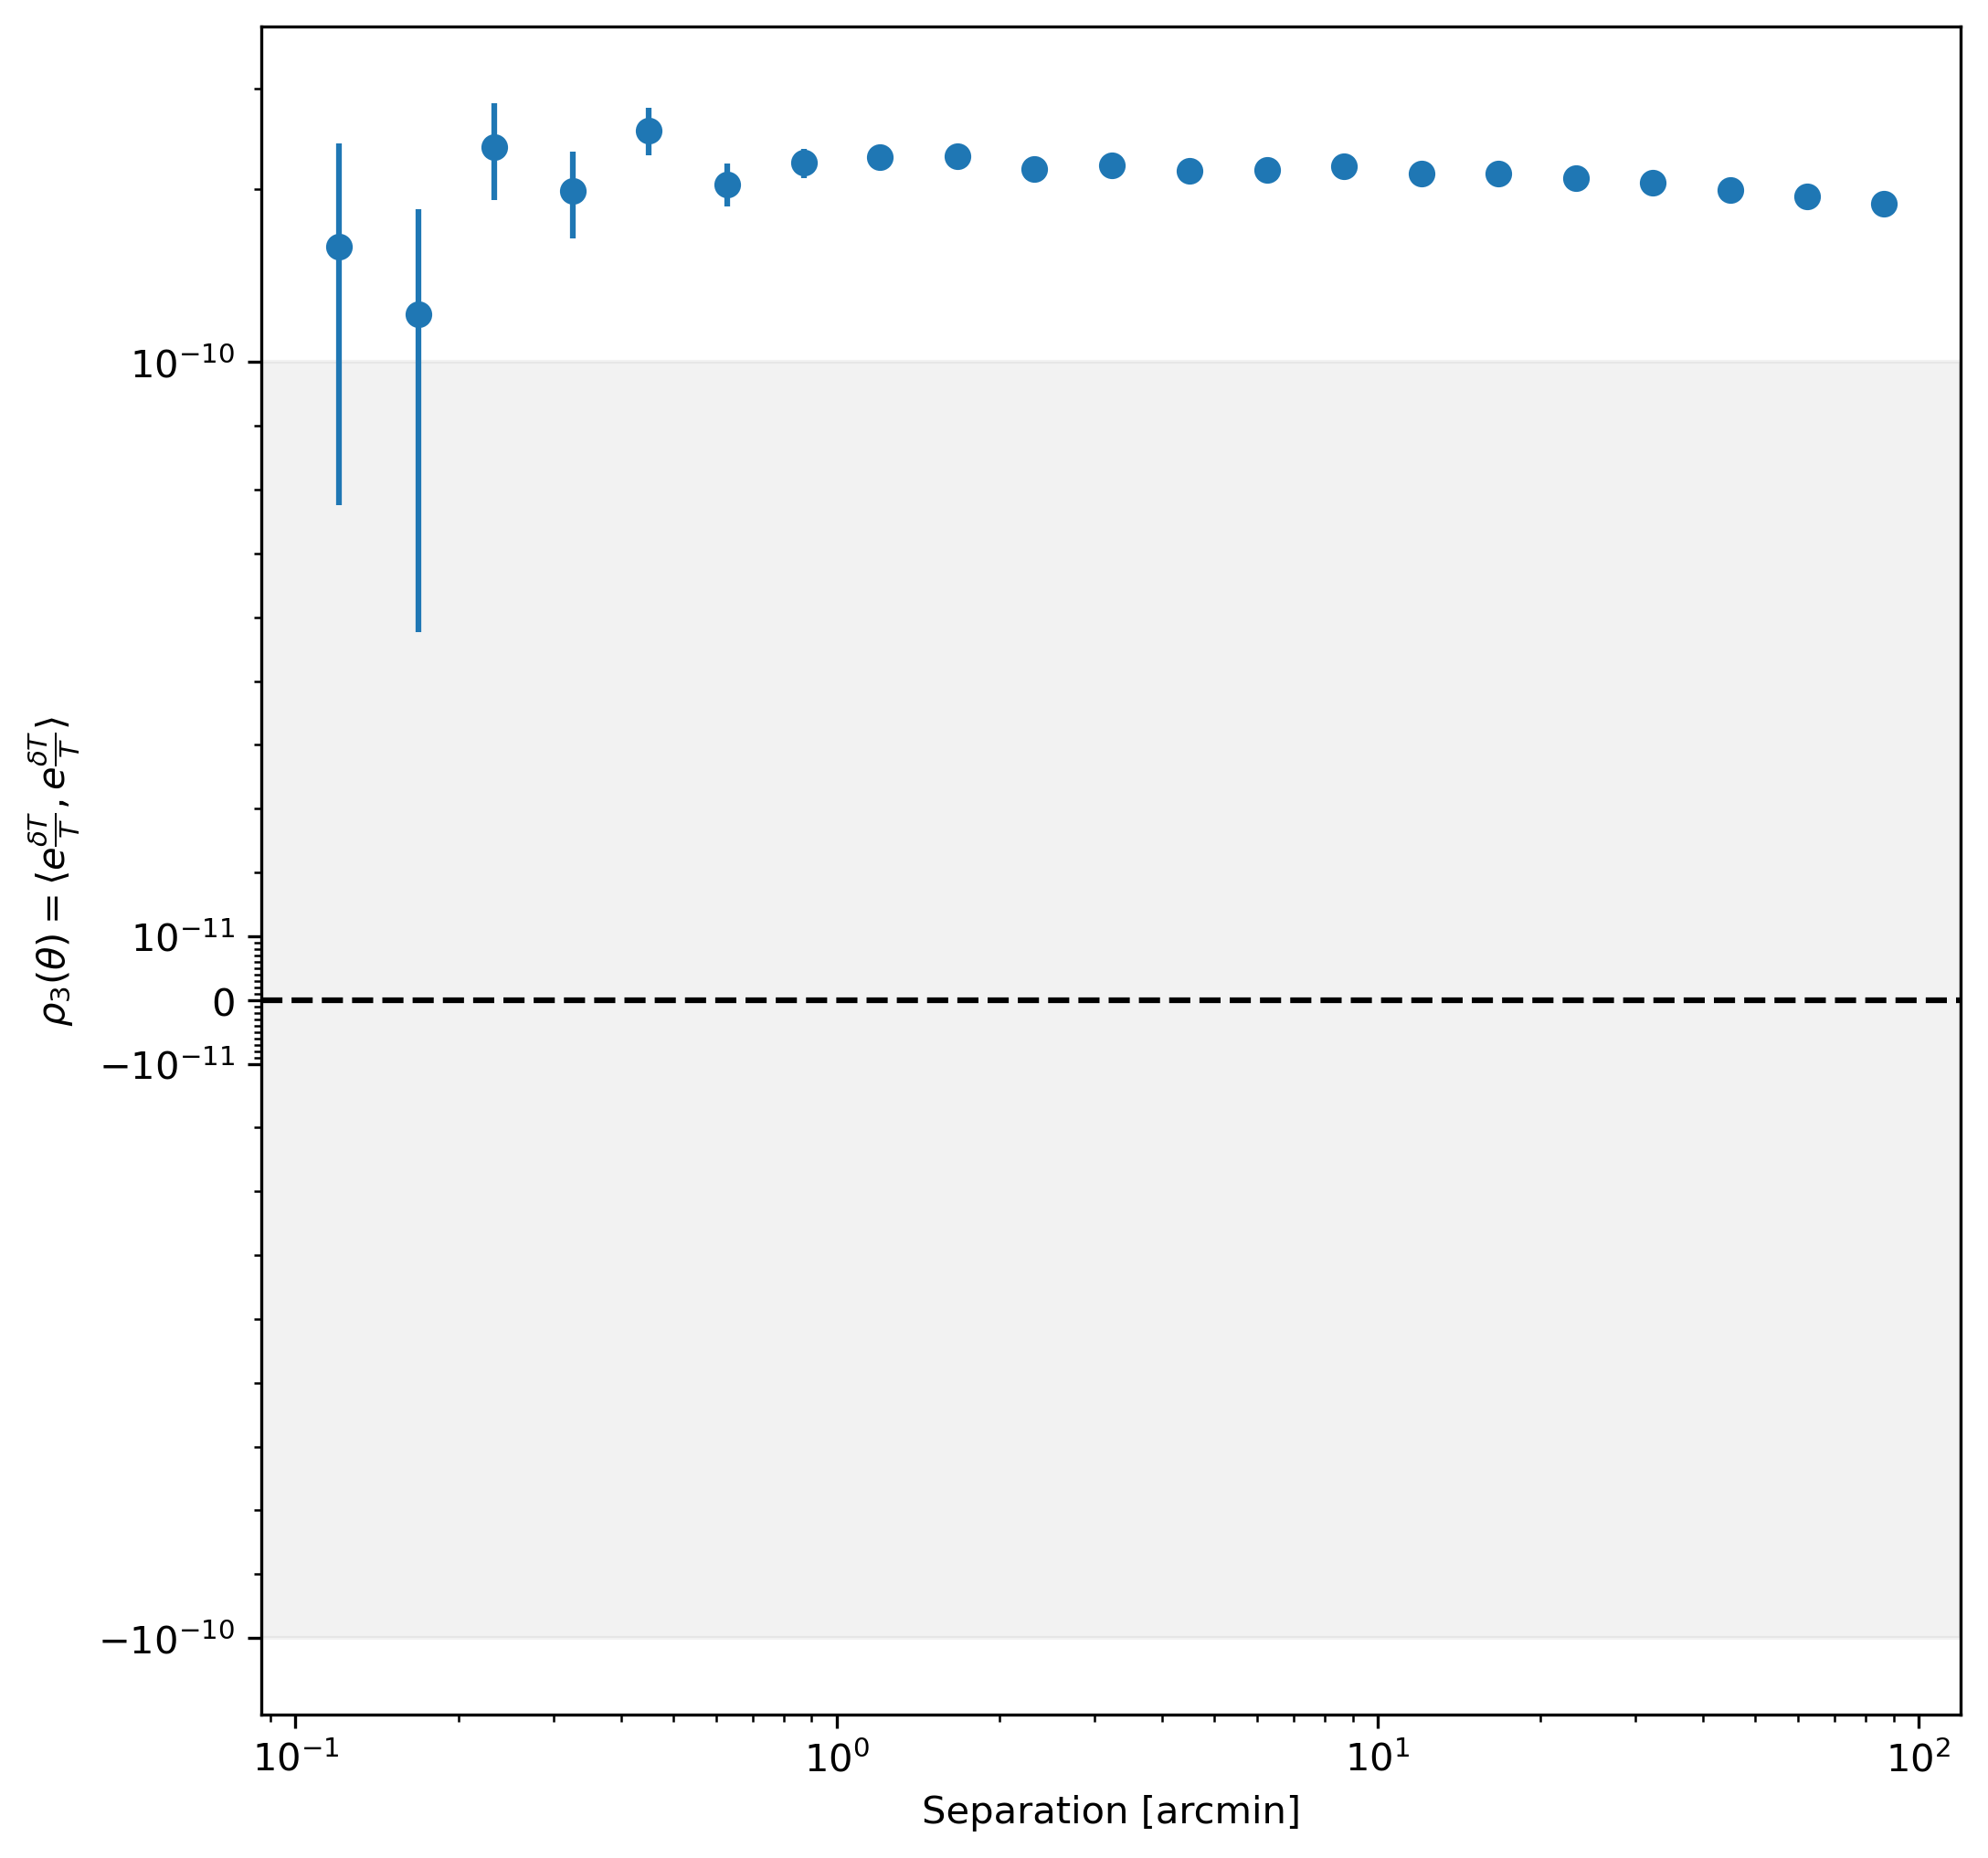

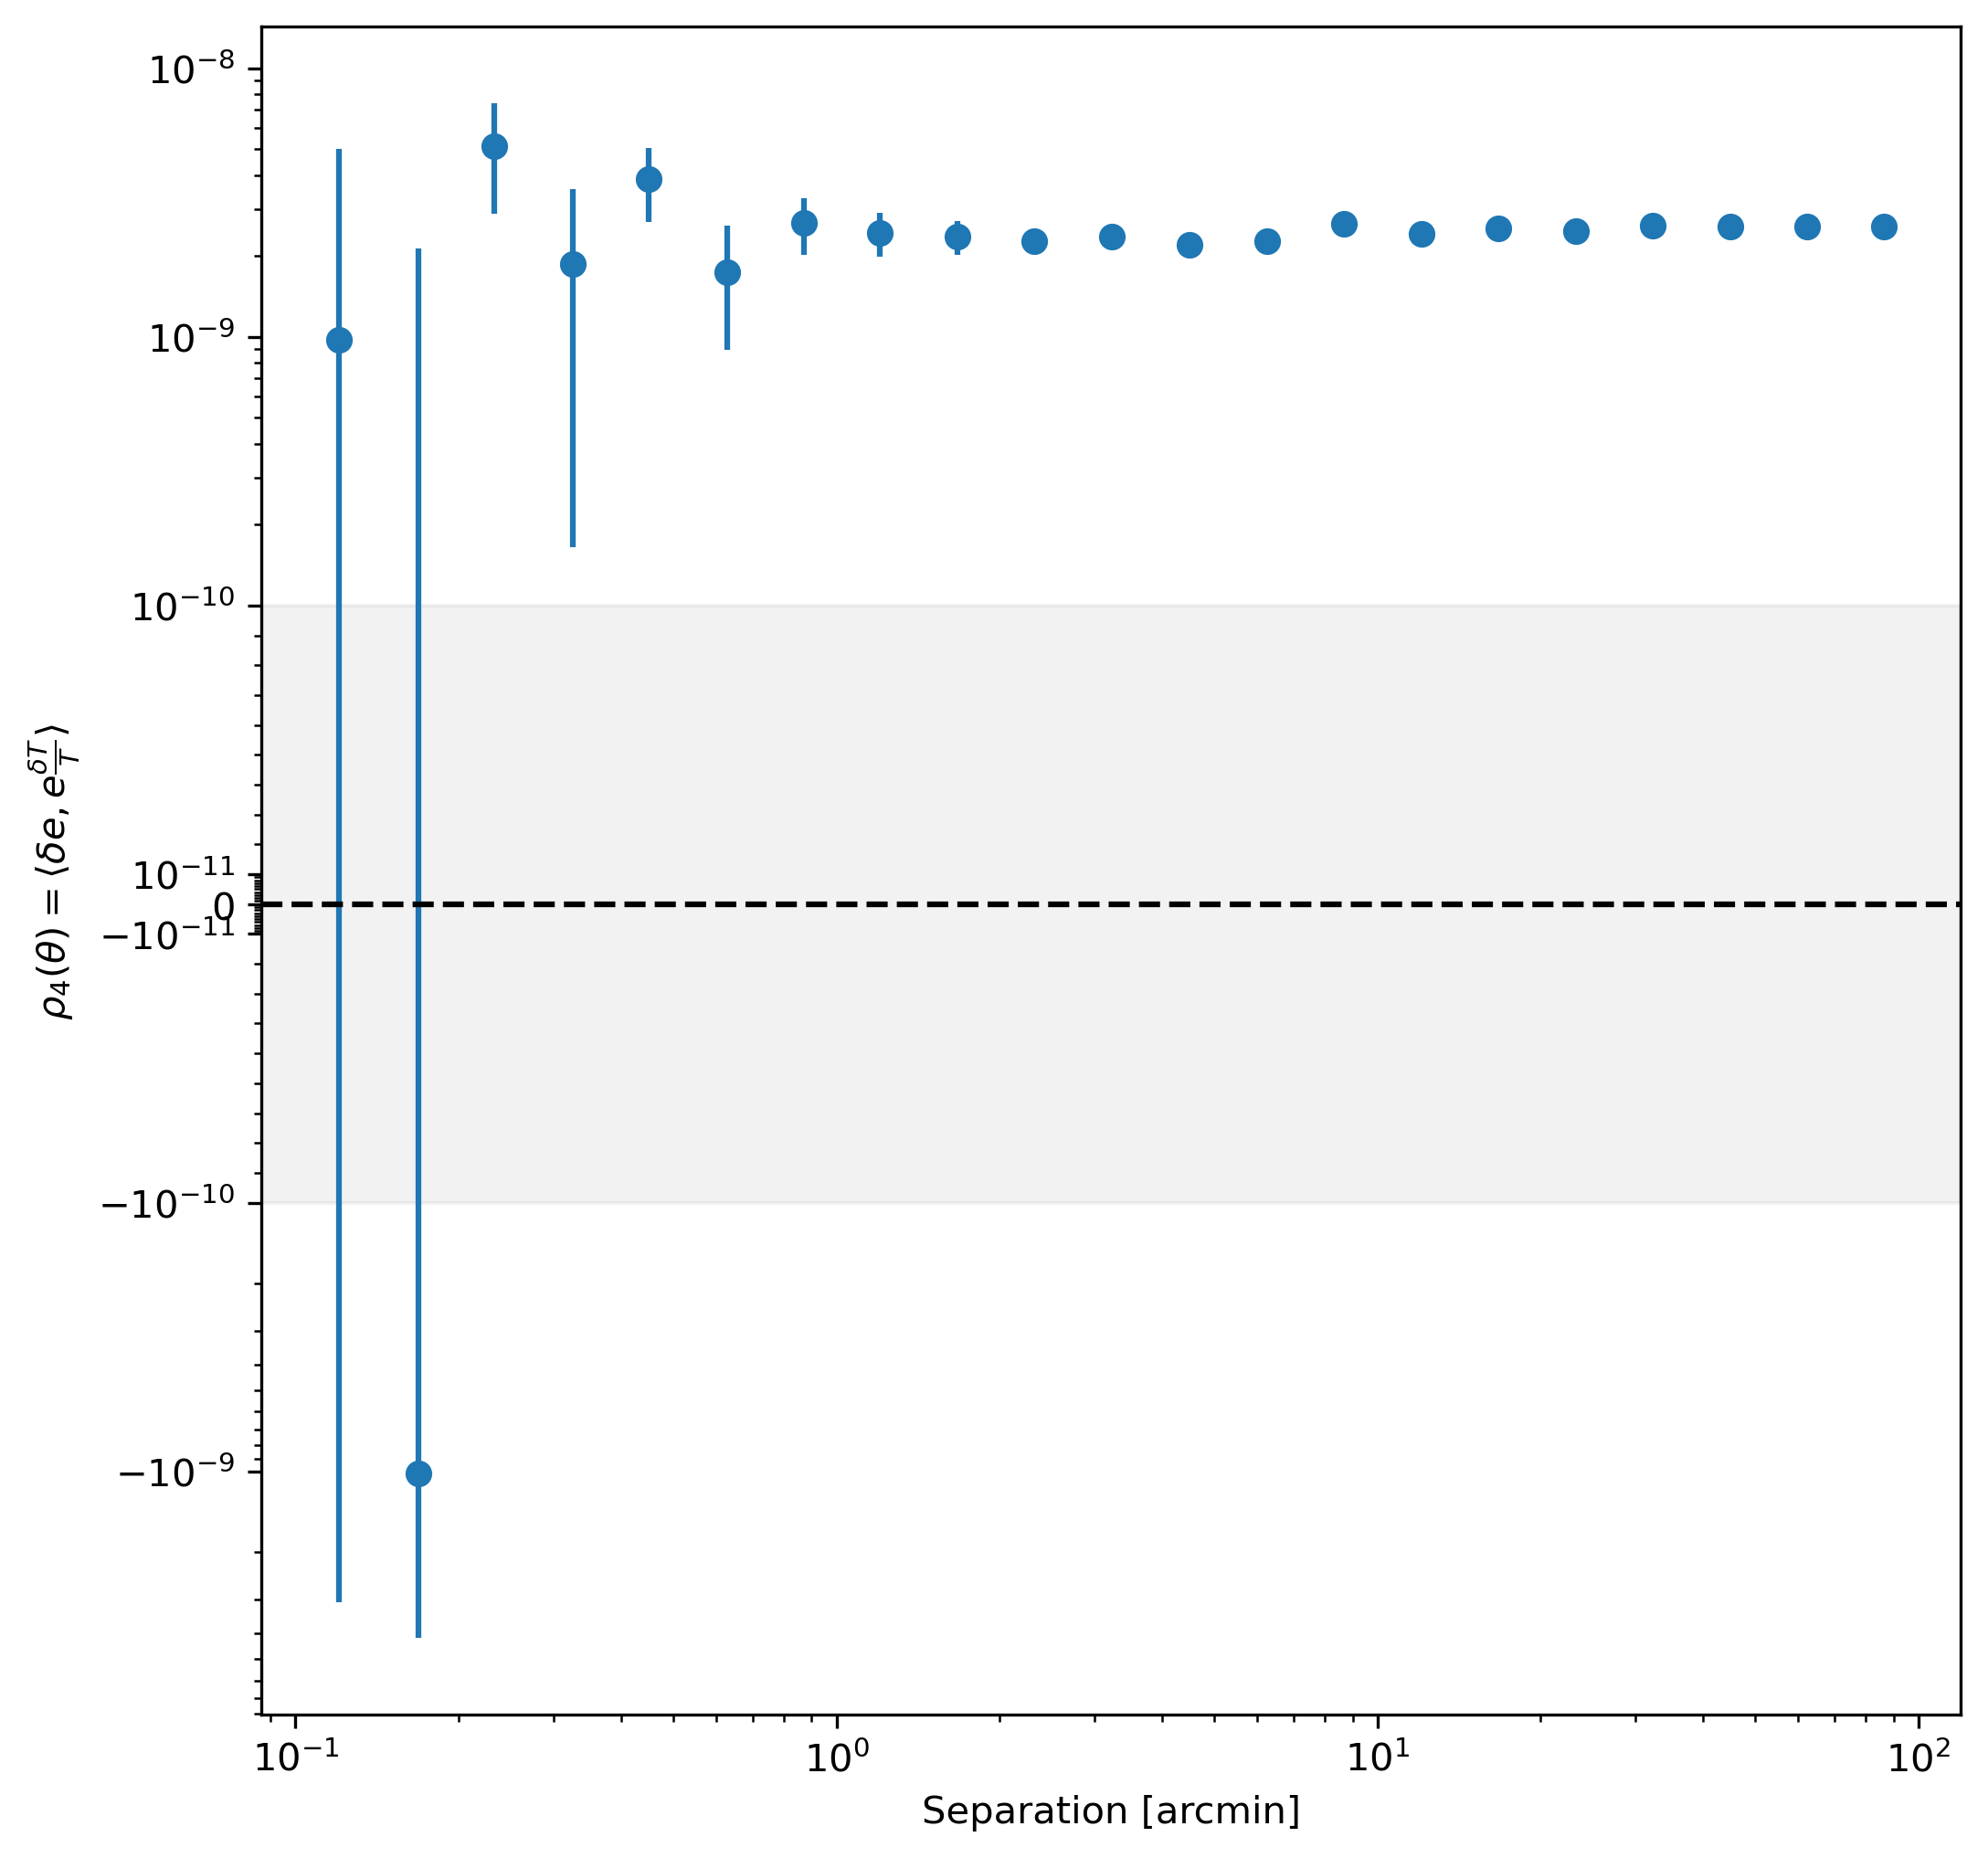

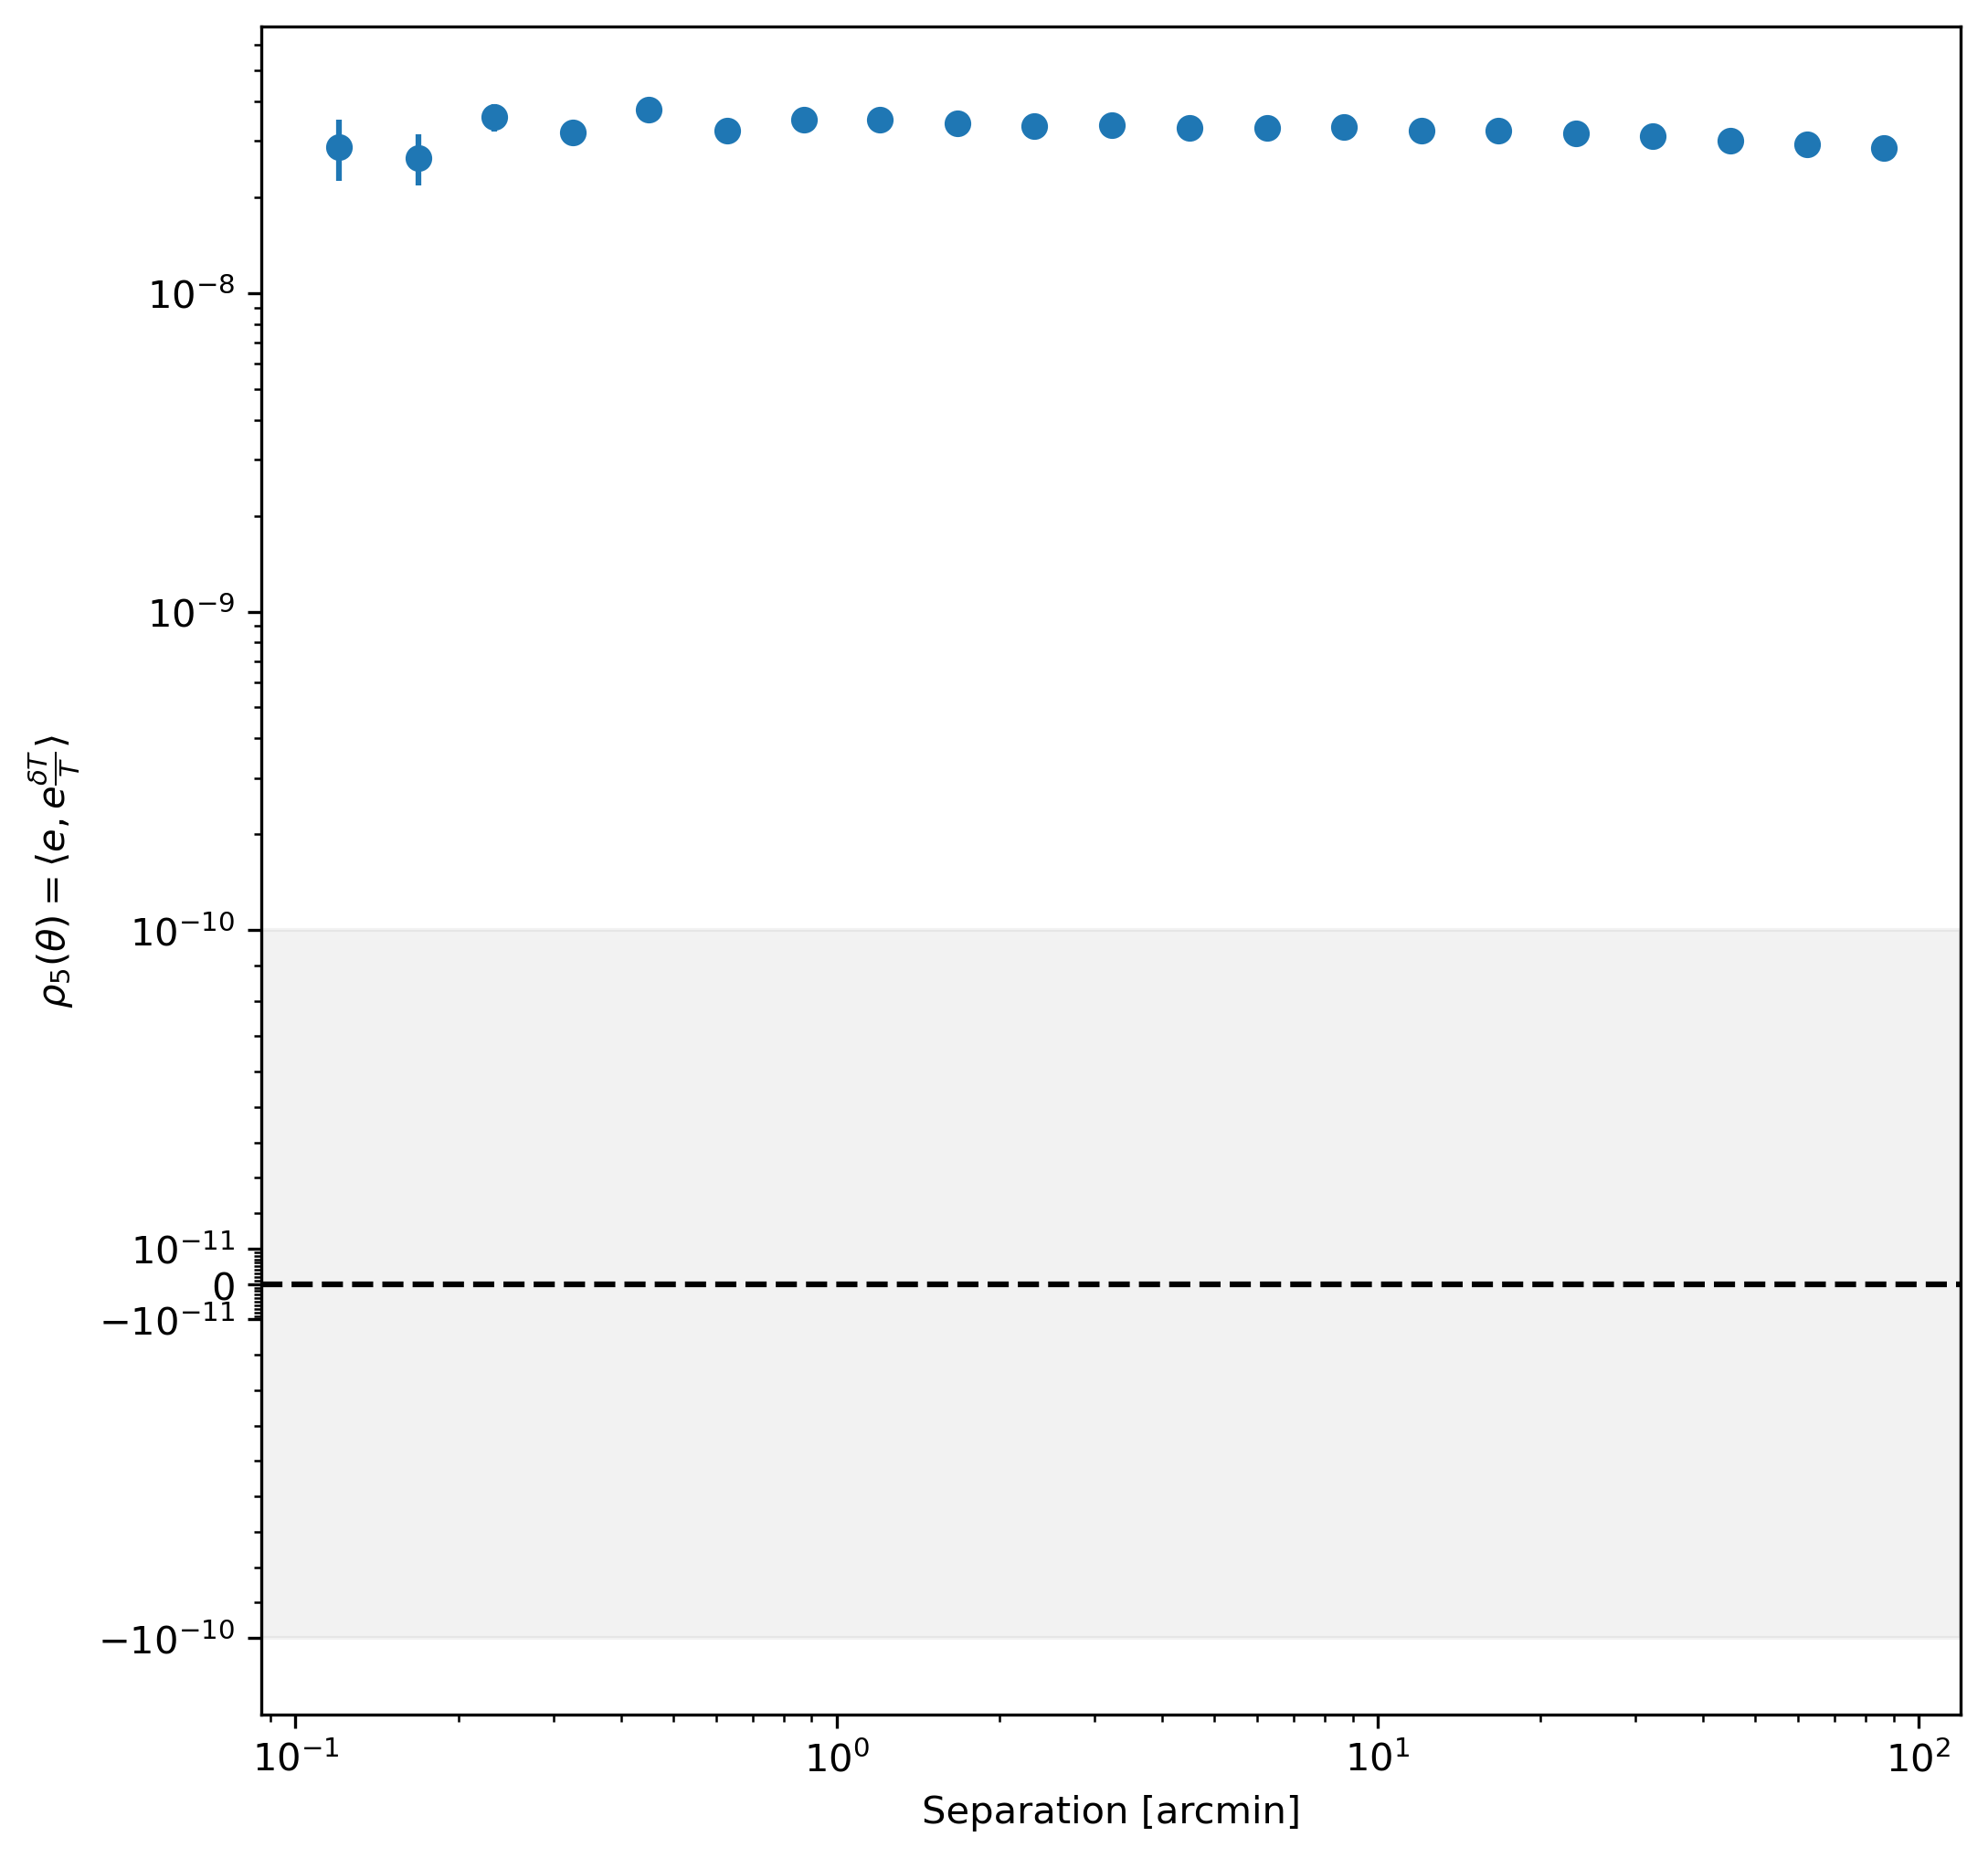

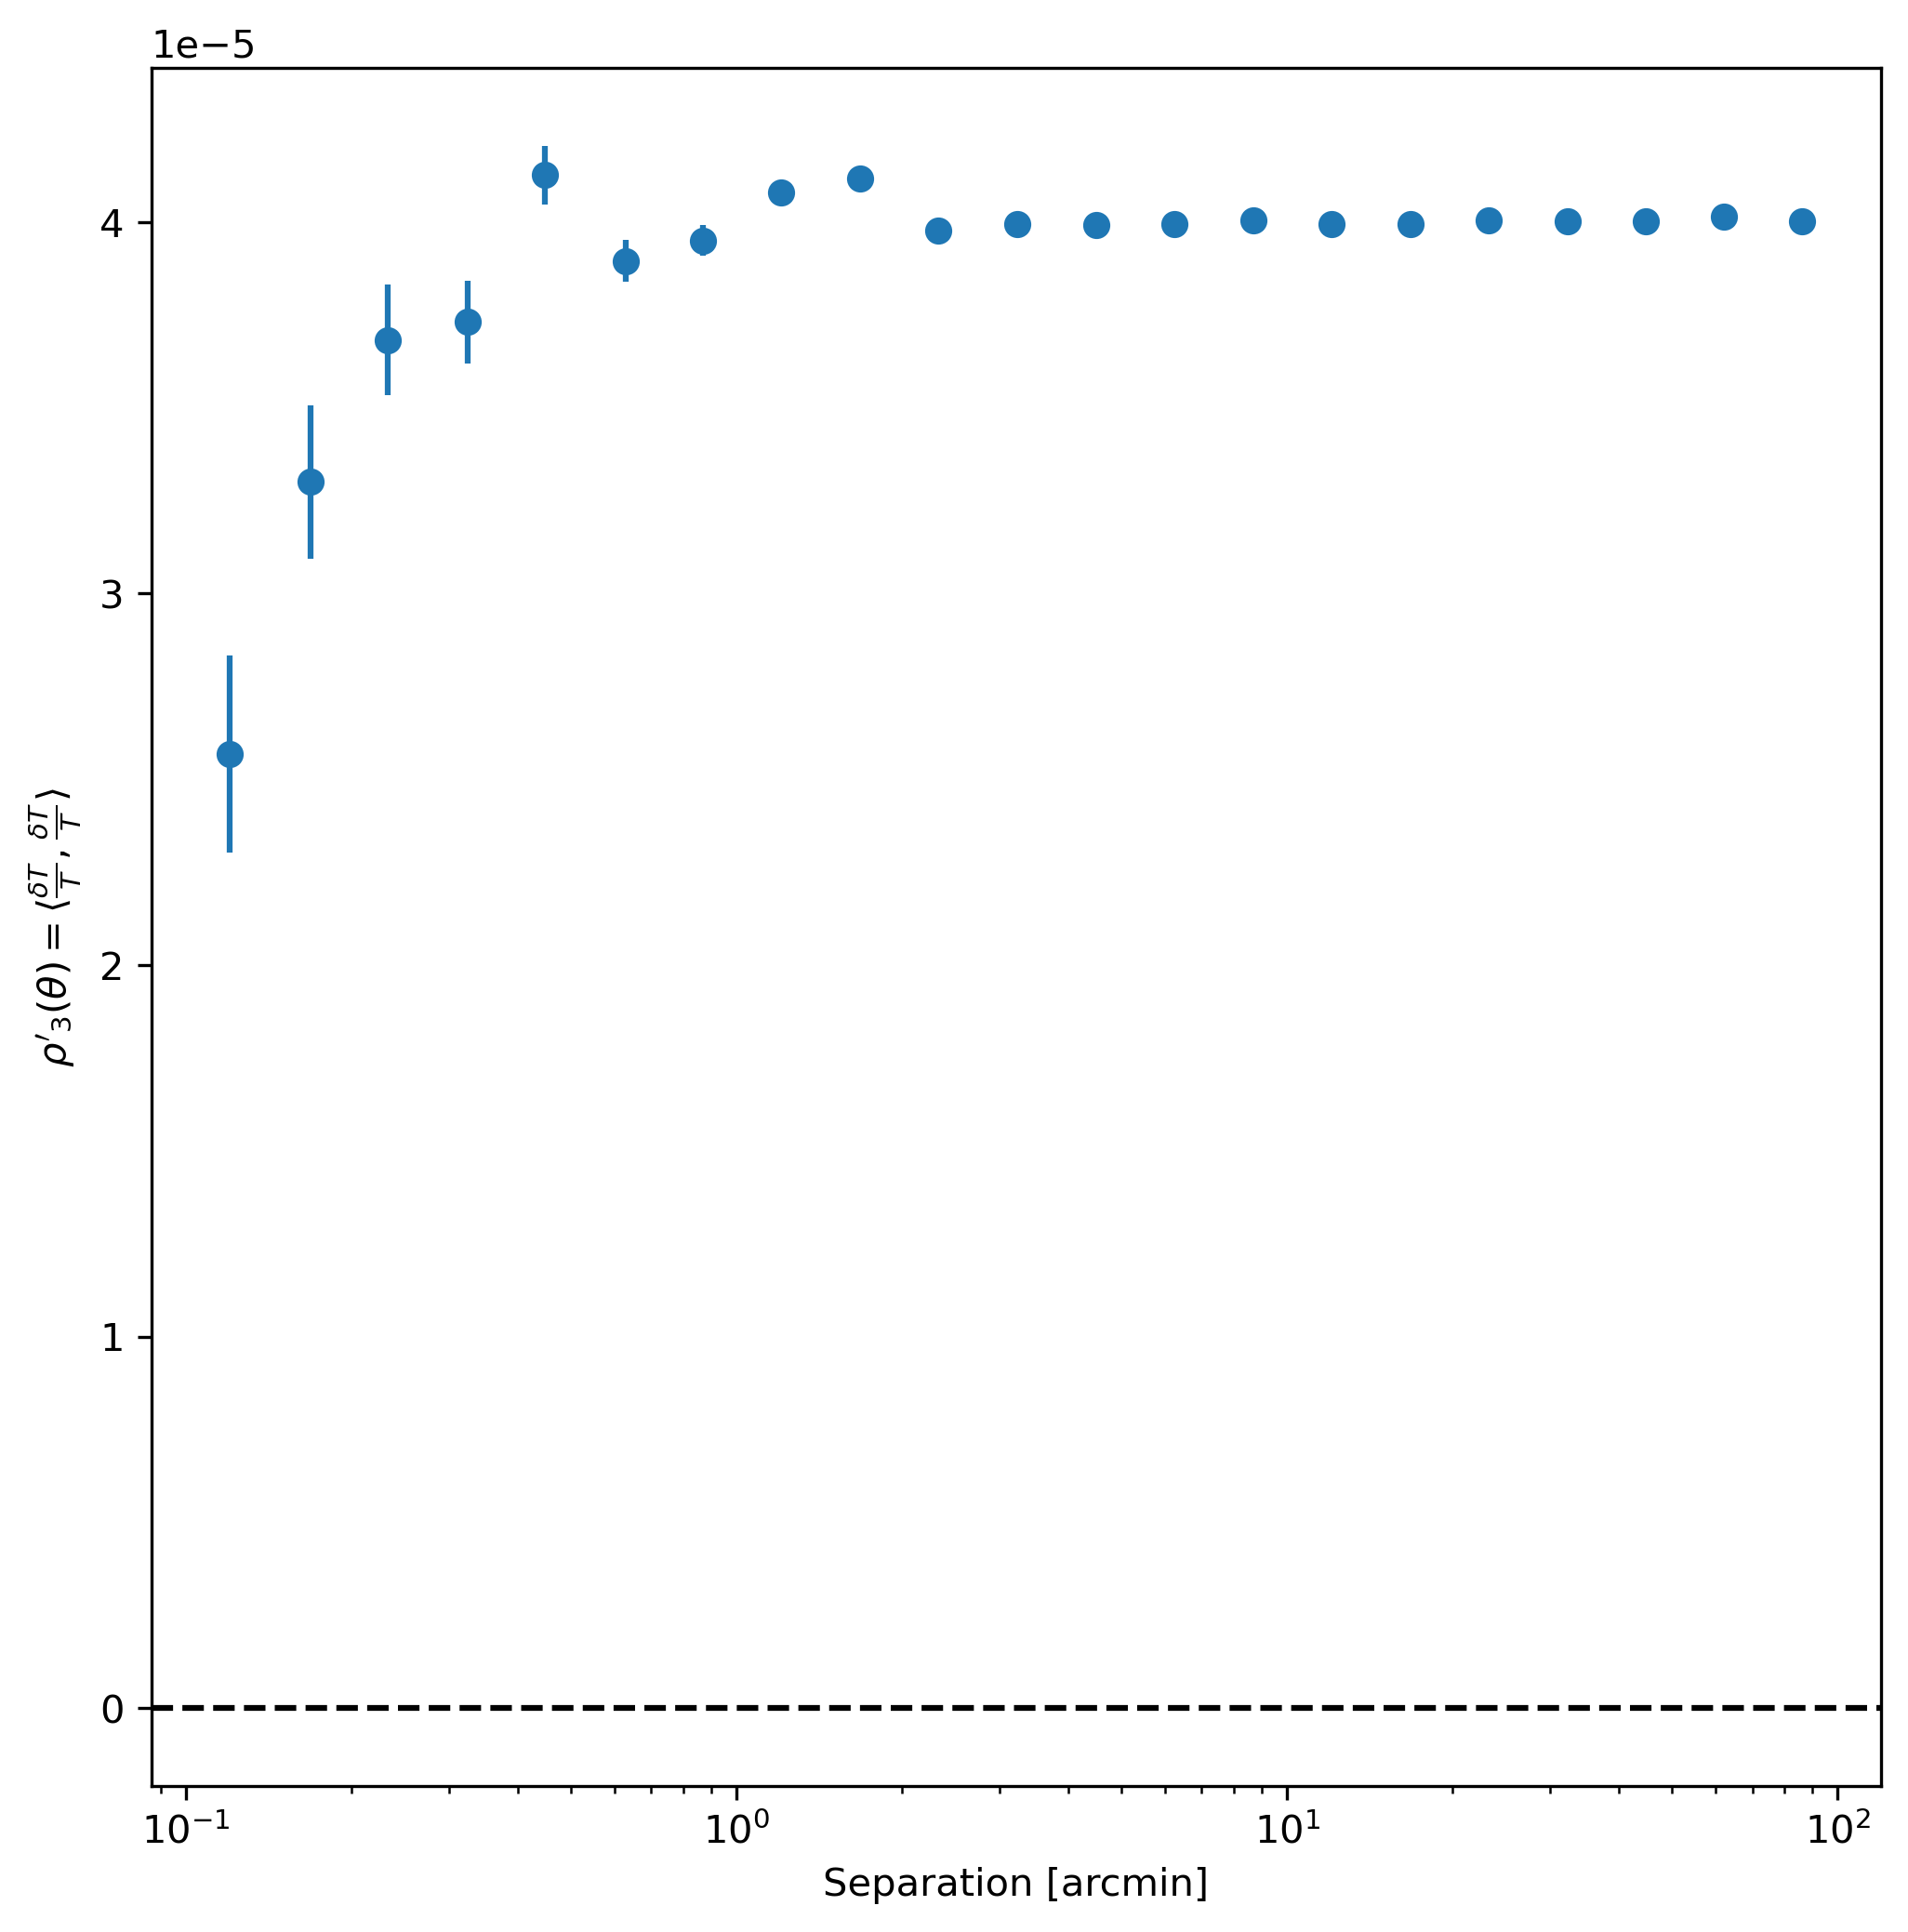

In [66]:
produceResults = atool.produce(processResults, band='i', skymap=None)

We can also print the results from `treecorr`

In [67]:
pprint(processResults['rho4'].meanr)
pprint(processResults['rho4'].xip)
pprint(processResults['rho4'].varxip)

array([ 0.12017311,  0.1685459 ,  0.23266689,  0.32544924,  0.44883092,
        0.62813329,  0.86999208,  1.20282896,  1.67413031,  2.3241002 ,
        3.23514482,  4.49575909,  6.24488969,  8.68315973, 12.06400542,
       16.75441258, 23.27609725, 32.32357124, 44.88376034, 62.2863356 ,
       86.25761076])
array([ 9.75690501e-10, -1.01607142e-09,  5.14501578e-09,  1.86426270e-09,
        3.86671398e-09,  1.74777359e-09,  2.64911249e-09,  2.44227903e-09,
        2.35967648e-09,  2.27138715e-09,  2.36141438e-09,  2.19528745e-09,
        2.27853690e-09,  2.64252542e-09,  2.42414235e-09,  2.54524062e-09,
        2.47555589e-09,  2.59201411e-09,  2.57300772e-09,  2.58324529e-09,
        2.56786992e-09])
array([1.63531031e-17, 9.95406277e-18, 5.12559949e-18, 2.88584173e-18,
       1.42495919e-18, 7.32228498e-19, 3.96553309e-19, 2.06255355e-19,
       1.09717305e-19, 5.70220283e-20, 2.99415986e-20, 1.57086735e-20,
       8.17275707e-21, 4.30139990e-21, 2.25969683e-21, 1.19665400e-21,
       